In [1]:
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc import MCMC, HMC, NUTS
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import torch.distributions.constraints as constraints

import numpy as np
import scipy.stats as stats
import pandas as pd

import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

%matplotlib inline

In [2]:
assert pyro.__version__.startswith('1.8.1')
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)
# Enable smoke test - run the notebook cells on CI.
#smoke_test = 'CI' in os.environ

In [3]:
device = torch.device('cpu')
# if torch.cuda.is_available():
#     device = torch.device('cuda:0')

In [4]:
from torch.distributions.utils import (_sum_rightmost, broadcast_all,
                                       lazy_property, tril_matrix_to_vec,
                                       vec_to_tril_matrix)

In [5]:
def make_pd_mat(size, tensor_of_vectors):
    x = vec_to_tril_matrix(tensor_of_vectors)
    for idx in range(size):
        x[:, idx, idx] = torch.exp(x[:, idx, idx])
    z_scale = torch.bmm(x, x.transpose(1, 2))
    return z_scale

In [6]:
import torch.nn.functional as F
# define the PyTorch module that parameterizes the
# diagonal gaussian distribution q(z|x)
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, input_dim):
        super(Encoder, self).__init__()
        self.z_dim = z_dim
        self.input_dim = input_dim
        # setup the three linear transformations used
        self.fc1 = nn.Linear(input_dim[0]*input_dim[1], hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        val = int((z_dim**2 + z_dim) / 2)
        self.fc22 = nn.Linear(hidden_dim, val) # z_dim**2)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x):
        # then compute the hidden units
        hidden = self.fc1(x.reshape(x.shape[0], self.input_dim[0] * self.input_dim[1]))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        A_vect = self.fc22(hidden)
        A = vec_to_tril_matrix(A_vect)
        z_scale = torch.bmm(A, A.transpose(1, 2))
        z_scale.add_(torch.eye(self.z_dim)*1e-4)
        return z_loc, z_scale


# define the PyTorch module that parameterizes the
# observation likelihood p(x|z)
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, input_dim):
        super(Decoder, self).__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, input_dim)
        self.fc22 = nn.Linear(hidden_dim, input_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, z):
        # define the forward computation on the latent z
        # first compute the hidden units
        hidden = self.softplus(self.fc1(z))
        mu = self.fc21(hidden)
        sigma = torch.exp(self.fc22(hidden))
        return mu, sigma


# define a PyTorch module for the VAE
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, input_dim,
        z_dim=5, hidden_dim=250, use_cuda=False):
        super(VAE, self).__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim, input_dim=input_dim)
        # self.decoder = Decoder(z_dim, hidden_dim, input_dim=input_dim)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, sigma, x):
        # register PyTorch module `decoder` with Pyro
        # pyro.module("decoder", self.decoder)
        
        # setup hyperparameters for prior p(z)
        mu_loc = torch.zeros(x.shape[0], self.z_dim, dtype=x.dtype, device=x.device)
        mu_scale = torch.eye(x[0].shape[1]).reshape(
            (1,x[0].shape[1],x[0].shape[1])).repeat(x.shape[0], 1, 1)

        for i in pyro.plate("batch_loop", x.shape[0]):
            
            # sample from prior (value will be sampled by guide when computing the ELBO
            mu = pyro.sample("latent_{}".format(i), dist.MultivariateNormal(mu_loc[i,:], mu_scale[i,:,:]))
            scale = pyro.param("scale_{}".format(i), torch.eye(x[i].shape[1]).reshape(
                (1,x[i].shape[1],x[i].shape[1])))
            
            with pyro.plate("data_loop_{}".format(i), x[i].shape[0]):
                pyro.sample("obs_{}".format(i), dist.MultivariateNormal(mu, scale),
                                obs=x[i, :, :])          
            
    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, sigma, x):
        
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)

        for i in pyro.plate("batch_loop", x.shape[0]):
            
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale = self.encoder.forward(x[i].unsqueeze(0))

            # sample the latent code z
            z = pyro.sample("latent_{}".format(i), dist.MultivariateNormal(z_loc, z_scale))
            
            scale = pyro.param("scale_{}".format(i), torch.eye(x[i].shape[1]).reshape(
                (1,x[i].shape[1],x[0].shape[1])))#.repeat(x.shape[i], 1, 1))

In [7]:
# write a function to find this exact posterior 
def get_posterior_cov_mv_gaussian(n, sigma, sigma_0):
    sum_part = sigma_0 + 1/n * sigma
    sum_part = np.linalg.inv(sum_part)
    p1 = np.matmul(sigma_0, sum_part)
    p2 = np.matmul(p1, 1/n * sigma)
    return(p2)

def get_posterior_mean_mv_gaussian(n, sigma, sigma_0, mu_0, data):
    sum_part = sigma_0 + 1/n * sigma
    sum_part = np.linalg.inv(sum_part)
    
    middle_part = data.mean(axis=0)
    
    p1 = np.matmul(sigma_0, sum_part)
    p2 = np.matmul(p1, middle_part)
    
    p3 = np.matmul(1/n * sigma, sum_part)
    p4 = np.matmul(p3, mu_0)
    return(p2 + p4)

In [8]:
def multivar_random(size, normal_params, gamma_params, num_samples):   

    # simulate two random covariance matrices (PSD) for sigma and sigma_0
    mat = np.random.gamma(gamma_params[0], gamma_params[1], size=size**2).reshape((size, size))
    sigma_mat = torch.tensor(np.dot(mat, mat.transpose()))
    
    mat_0 = np.random.gamma(gamma_params[2], gamma_params[3], size=size**2).reshape((size, size))
    sigma_mat_0 = torch.tensor(np.dot(mat_0, mat_0.transpose()))
    
    # simulate some random means
    mu_vector = torch.tensor(np.random.multivariate_normal(normal_params, sigma_mat_0, size=1))[0]

    # now simulate multivariate gaussian
    data = torch.tensor(np.random.multivariate_normal(mu_vector, sigma_mat, size=num_samples).astype("float32"))
    
    return(data, mu_vector, sigma_mat, sigma_mat_0)

In [9]:
X = []
means = []
sigma_mats = []
sigma_0s = []
for idx in range(10000):
    random_means = np.random.sample(size=5) 
    
    data, mu_vector, sigma_mat, sigma_mat_0 = multivar_random(5, [1]*5, [0.5,.5,.5,.5], num_samples=500)
    X.append(data)
    means.append(mu_vector)
    sigma_mats.append(sigma_mat)
    sigma_0s.append(sigma_mat_0)

In [10]:
# clear param store
pyro.clear_param_store()

no_instances = 20000
input_dim = (500, 5)
mu = stats.norm.rvs(size=input_dim)

# setup the VAE
vae = VAE(use_cuda=False, input_dim=input_dim, z_dim=5)

adam_args = {"lr": 0.00001}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())
train_loader = DataLoader(X, batch_size=5000, shuffle=True,
     num_workers=1, pin_memory=True, drop_last=False)

train_elbo = []

for epoch in range(50):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    print("Epoch: ", epoch, end = "\r")
    for x in train_loader:
        # x = x.cuda()
        epoch_loss += svi.step(torch.eye(input_dim[1]), x)

    # report training diagnostics
    if not epoch % 2:
        normalizer_train = len(train_loader.dataset)
        total_epoch_loss_train = epoch_loss / normalizer_train
        train_elbo.append(total_epoch_loss_train)
        print("[epoch %03d]  average training loss: %.4f" %
             (epoch, total_epoch_loss_train))

[epoch 000]  average training loss: 7317.3489
[epoch 002]  average training loss: 6288.1222
[epoch 004]  average training loss: 5522.7617
[epoch 006]  average training loss: 5061.7089
[epoch 008]  average training loss: 4813.6559
[epoch 010]  average training loss: 4652.8888
[epoch 012]  average training loss: 4559.8410
[epoch 014]  average training loss: 4468.6739
[epoch 016]  average training loss: 4408.3098
[epoch 018]  average training loss: 4331.4887
[epoch 020]  average training loss: 4260.4578
[epoch 022]  average training loss: 4213.3752
[epoch 024]  average training loss: 4158.1235
[epoch 026]  average training loss: 4119.4549
[epoch 028]  average training loss: 4089.0328
[epoch 030]  average training loss: 4076.4150
[epoch 032]  average training loss: 4049.0717
[epoch 034]  average training loss: 4039.8073
[epoch 036]  average training loss: 4019.3533
[epoch 038]  average training loss: 4006.3014
[epoch 040]  average training loss: 4011.0446
[epoch 042]  average training loss

Text(0, 0.5, 'ELBO loss')

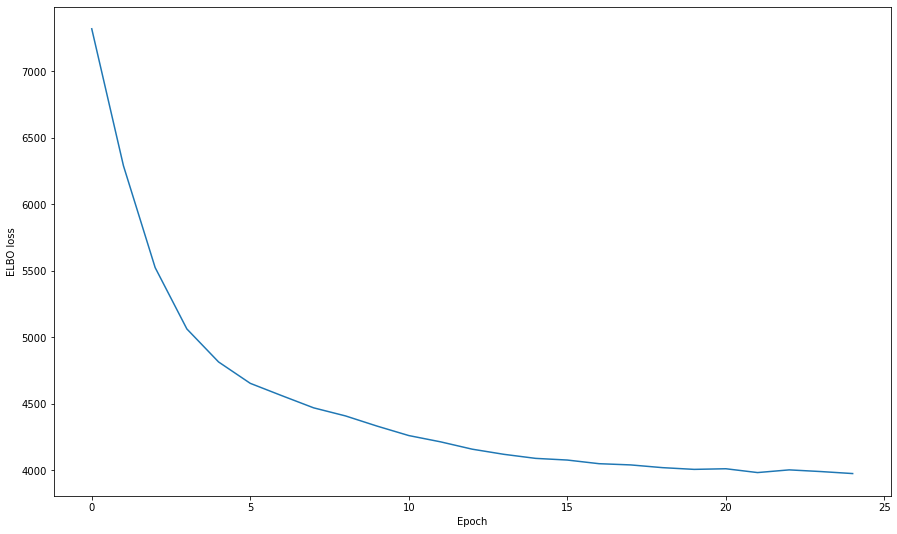

In [11]:
plt.figure(figsize=(15, 9))
plt.plot([i for i in range(len(train_elbo))], train_elbo)
plt.xlabel("Epoch")
plt.ylabel("ELBO loss")

In [22]:
count = 0
for name, value in pyro.get_param_store().items():
    print(name)

encoder$$$fc1.weight
encoder$$$fc1.bias
encoder$$$fc21.weight
encoder$$$fc21.bias
encoder$$$fc22.weight
encoder$$$fc22.bias
scale_0
scale_1
scale_2
scale_3
scale_4
scale_5
scale_6
scale_7
scale_8
scale_9
scale_10
scale_11
scale_12
scale_13
scale_14
scale_15
scale_16
scale_17
scale_18
scale_19
scale_20
scale_21
scale_22
scale_23
scale_24
scale_25
scale_26
scale_27
scale_28
scale_29
scale_30
scale_31
scale_32
scale_33
scale_34
scale_35
scale_36
scale_37
scale_38
scale_39
scale_40
scale_41
scale_42
scale_43
scale_44
scale_45
scale_46
scale_47
scale_48
scale_49
scale_50
scale_51
scale_52
scale_53
scale_54
scale_55
scale_56
scale_57
scale_58
scale_59
scale_60
scale_61
scale_62
scale_63
scale_64
scale_65
scale_66
scale_67
scale_68
scale_69
scale_70
scale_71
scale_72
scale_73
scale_74
scale_75
scale_76
scale_77
scale_78
scale_79
scale_80
scale_81
scale_82
scale_83
scale_84
scale_85
scale_86
scale_87
scale_88
scale_89
scale_90
scale_91
scale_92
scale_93
scale_94
scale_95
scale_96
scale_97
scal

In [23]:
vae.encoder.eval()

Encoder(
  (fc1): Linear(in_features=2500, out_features=250, bias=True)
  (fc21): Linear(in_features=250, out_features=5, bias=True)
  (fc22): Linear(in_features=250, out_features=15, bias=True)
  (softplus): Softplus(beta=1, threshold=20)
)

In [24]:
idx = 0
X[idx].shape
mean_pred = vae.encoder.forward(X[idx].unsqueeze(0))[0]
mean_act = means[idx]
print("Predicted means: {}.".format(mean_pred))
print("Actual means: {}.".format(mean_act))

Predicted means: tensor([[ 0.5866,  1.0219,  1.3118,  0.7396, -0.7185]],
       grad_fn=<AddmmBackward0>).
Actual means: tensor([ 0.8855,  0.9093,  0.8844,  0.6108, -0.5947], dtype=torch.float64).


In [43]:
x_i, mu_vector, sigma, sigma_0 = multivar_random(5, [0] * 5, [.5]*4, 500)
mean_pred = vae.encoder.forward(x_i.reshape(1, 500, 5))[0]
mean_act = get_posterior_mean_mv_gaussian(50, sigma, sigma_0, mu_vector, x_i)
sigma_act = get_posterior_cov_mv_gaussian(50, sigma, sigma_0)
print("Predicted means: {}.".format(mean_pred))
print("Actual means: {}.".format(mean_act))

Predicted means: tensor([[-0.4741,  0.3206, -0.0194,  0.9588, -0.5181]],
       grad_fn=<AddmmBackward0>).
Actual means: [-0.11983277  0.26282214 -0.08267867  1.09128103 -0.35223856].


In [26]:
mean_sigma = vae.encoder.forward(x_i.reshape(1, 500, 5))[1]
mean_sigma

tensor([[[ 0.4368,  0.3264,  0.1015,  0.0101, -0.1578],
         [ 0.3264,  1.1040, -0.2925, -0.4214, -0.4302],
         [ 0.1015, -0.2925,  0.3093, -0.0547,  0.1255],
         [ 0.0101, -0.4214, -0.0547,  0.7270,  0.1112],
         [-0.1578, -0.4302,  0.1255,  0.1112,  0.2537]]],
       grad_fn=<AddBackward0>)

In [27]:
post_sigma = get_posterior_cov_mv_gaussian(500, sigma, sigma_0)

In [44]:
mean_pred[0][0]

tensor(-0.4741, grad_fn=<SelectBackward0>)

In [50]:
mean_pred = mean_pred.detach().numpy()
mean_sigma = mean_sigma.detach().numpy()
mean_act = mean_act.detach().numpy()
sigma_act = sigma_act.detach().numpy()

In [30]:
post_mean = get_posterior_mean_mv_gaussian(500, sigma, sigma_0, mu_vector, data)

In [31]:
mean_sigma[0]

array([[ 0.4368409 ,  0.3263902 ,  0.10153512,  0.01014484, -0.15780757],
       [ 0.3263902 ,  1.1039706 , -0.2925335 , -0.42143804, -0.43018067],
       [ 0.10153512, -0.2925335 ,  0.3093035 , -0.05468893,  0.12548229],
       [ 0.01014484, -0.42143804, -0.05468893,  0.72702056,  0.11118991],
       [-0.15780757, -0.43018067,  0.12548229,  0.11118991,  0.25372908]],
      dtype=float32)

/Users/bennetthellman/opt/anaconda3/envs/py39/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/bennetthellman/opt/anaconda3/envs/py39/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/bennetthellman/opt/anaconda3/envs/py39/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword w

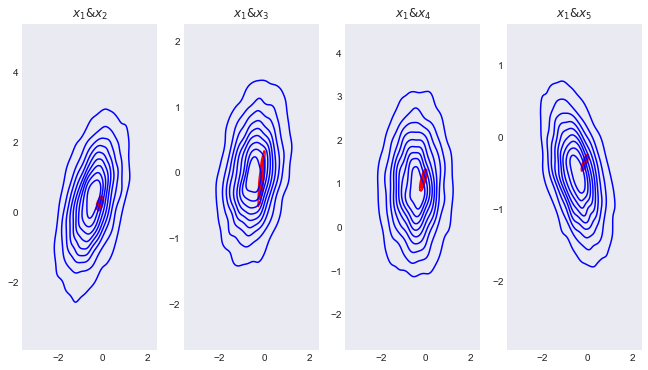

In [232]:
tru = np.random.multivariate_normal(mean_act, sigma_act, 5000).T
avi = np.random.multivariate_normal(mean_pred[0], mean_sigma[0], 5000).T
for idx, val in enumerate(sigma_act[0]):
    if idx<4:
        ax = plt.subplot(1,5,idx+1)
        sns.kdeplot(tru[0], tru[idx+1], label='True', color='Red')
        sns.kdeplot(avi[0], avi[idx+1], label='AVI', color='Blue').set(title = f'$x_1 & x_{idx+2}$')
        #plt.subplot(5,5,2*(idx+1))
        #sns.kdeplot(tru[1], tru[idx+1], label='True', color='Red')
        #sns.kdeplot(avi[1], avi[idx+1], label='AVI', color='Blue')